# Wisconsin Diagnostic Breast Cancer

569 instances with breast cancer dignosis (212 malignant, 357 benign) and 30 predictor variables.

See also original [UCI source](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

This dataset contains only continuous numeric data and has no missing values.
It allows for very good prediction results without further feature engineering.
Hence, is a good dataset for comparing different binary classification models.

In [1]:
from time import time
import numpy as np
import pandas as pd
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = datasets.load_breast_cancer()

# IMPORTANT: switch target labels as malignant should be 1

X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = 1-pd.Series(data['target'], name='target') # which labels

labels = data['target_names'][[1,0]]
display(X.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Split training and test data

In [3]:
from sklearn.model_selection import train_test_split

random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)

print("train: ", X_train.shape, ', test:', X_test.shape)

train:  (398, 30) , test: (171, 30)


# Model Training

Train and evaluate following models

* Logistic Regression
* Multi-layer Perceptron
* XGBoost

**Helper functions for visualizing model results:**

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report

def plot_roc(y_true, y_hat, ax):
    fpr, tpr, thres = roc_curve(y_true, y_hat)
    
    ax.plot(fpr, tpr, label='(AUC = %0.3f)' % auc(fpr, tpr))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title('ROC Curve')
    ax.legend()

def plot_pr_curve(y_true, y_hat, ax):
    prec, recl, thres = precision_recall_curve(y_true, y_hat)
    
    ax.plot(recl, prec, label='(AUC = %0.3f)' % auc(recl, prec))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision Recall Curve')
    ax.legend()

def plot_roc_thres(thresholds, ax):
    ax.plot(thresholds[1:], 'o--')
    ax.set_title('ROC Thresholds')

def adjust(ax, x=0, y=0, width=1, height=1):
    pos = ax.get_position()
    ax.set_position([pos.x0 + x, pos.y0 + y,  pos.width * width, pos.height * height])
    
def plot_conf_mat(y_true, y_hat, threshold, ax, class_labels=None):
    
    cm = pd.crosstab(y_true, np.int_(y_hat >= threshold), colnames=[f'Predicted (t={threshold:.2f})'], rownames=['Actual'])
    text=['', 'Type II error\n(False Alarm)', 'Type I error\n(Miss)', '']
    text=np.reshape([f"{t[0]}\n{t[1]}" for t in zip(cm.values.flatten(), text)], (2,2))
    sns.heatmap(cm, cmap='Blues', annot=text, ax=ax, cbar=False, fmt='s')
    #ax.set_title(f'threshold={threshold:.2f}')
    if class_labels is not None:
        ax.set_xticklabels(class_labels)
        ax.set_yticklabels(class_labels, va='center')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='both', which='major', left=False, top=False)
    ax.yaxis.labelpad = 6
    ax.xaxis.labelpad = 10

def plot_hist_pred(y_true, y_hat, ax, class_labels, youden=None, bins=25):
    labels = [f"{i[1]} ({i[0]})" for i in zip(class_labels, y_true.value_counts())]
    ax.hist([y_hat[y_true==0], y_hat[y_true==1]], stacked=True, label=labels, bins=25)
    ax.axvline(x=0.5, color='grey', linestyle='--')
    if youden != 0.5:
        ax.axvline(x=youden, color='r', linestyle='--', label=f'Youden: {youden:.3f}')
    ax.set_title('Predicted Probabilities')
    ax.legend(loc='upper center')

def plot_importances(booster, ax, importance_type='gain', num_features=20, normalize=True):
    '''See https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score
       xgb_best.feature_importances_ returns normalized "gain"'''
    types = {'weight': 'Number of times used in splits',
             'gain'  : 'Feature Importance (gain)'}
    s_scores = pd.Series(booster.get_score(importance_type=importance_type))
    if normalize:
        s_scores = s_scores / s_scores.sum()
    features=s_scores.sort_values(ascending=False).head(n=num_features)
    ax.bar(features.index, features)
    if importance_type in types:
        ax.set_title(types[importance_type])
    else:
        ax.set_title(importance_type)
    for tick in ax.get_xticklabels():
        tick.set(size=8, rotation=35, rotation_mode='anchor', ha='right')
    #ax.invert_yaxis()

def show_results(y_true, y_hat, labels, title=None, threshold=0.5, youden=False, report=False):
    
    fpr, tpr, thres = roc_curve(y_true, y_hat)
    if youden:
        threshold = thres[np.where(tpr-fpr == np.max(tpr-fpr))][0]
    
    fig, axs = plt.subplots(2,2, figsize=(8,6))
    
    plot_hist_pred(y_true, y_hat, axs[0,0], labels, youden=threshold)
    plot_roc(y_true, y_hat, axs[1,0])
    plot_conf_mat(y_true, y_hat, threshold, axs[0,1], labels)
    plot_pr_curve(y_true, y_hat, axs[1,1])
    #plot_roc_thres(thres, axs[1,1])
    
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    
    if report:
        print(classification_report(y_true, y_hat >= threshold))

## Logistic Regression

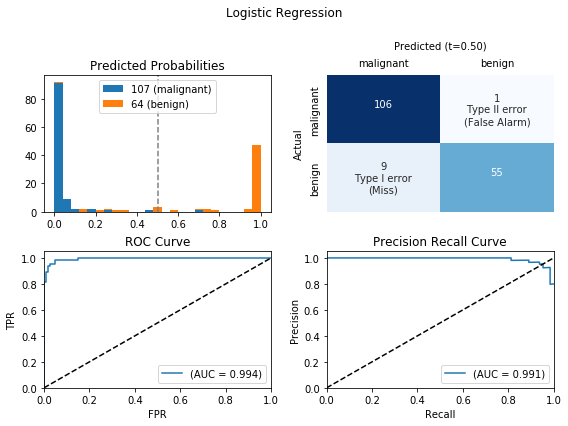

In [5]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)
y_hat = clf.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], title="Logistic Regression")

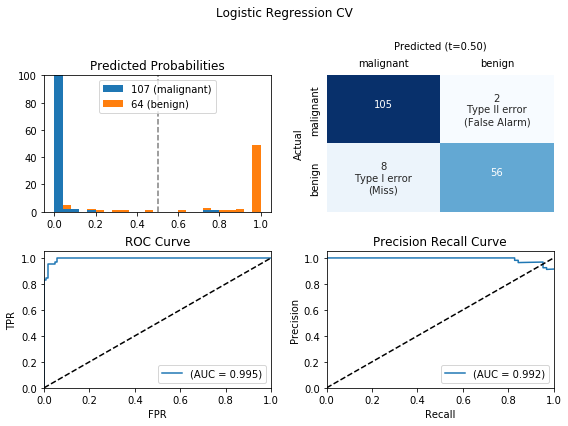

In [6]:
clf = LogisticRegressionCV(solver='liblinear', Cs=[0.001, 0.01, 0.1, 1.0, 10, 100], cv=10, verbose=0, max_iter=1000, class_weight=None, scoring='roc_auc')
clf.fit(X_train, y_train)
y_hat = clf.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], title="Logistic Regression CV")


In [7]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

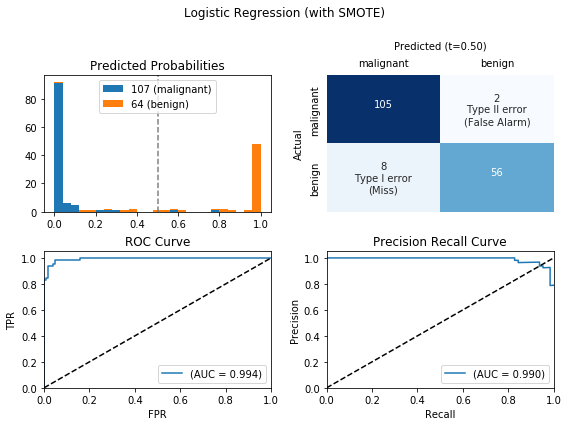

In [8]:
lr_ppl = ImbPipeline(steps = [('smote', SMOTE()), ('clf', LogisticRegression(solver='liblinear'))])
lr_ppl.fit(X_train, y_train)
y_hat = lr_ppl.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], title="Logistic Regression (with SMOTE)")

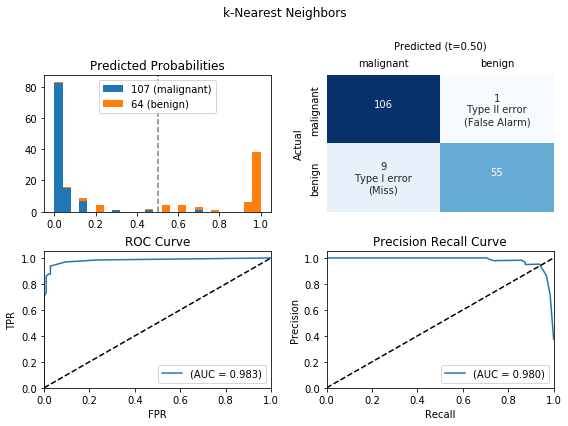

In [9]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=13)

clf.fit(X_train, y_train)
y_hat = clf.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], title="k-Nearest Neighbors")

## Multi-layer Perceptron

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

ppl_mlp = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(max_iter=2000))
])

-> took 1.8 seconds


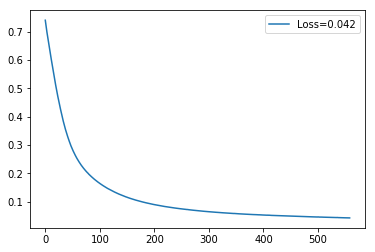

In [11]:
start = time()
ppl_mlp.fit(X_train, y_train)
print('-> took %.1f seconds' % (time() - start))

def show_loss(clf):
    plt.plot(clf.loss_curve_, label=f"Loss={clf.loss_:0.3f}")
    plt.legend()

show_loss(ppl_mlp.named_steps['mlp'])

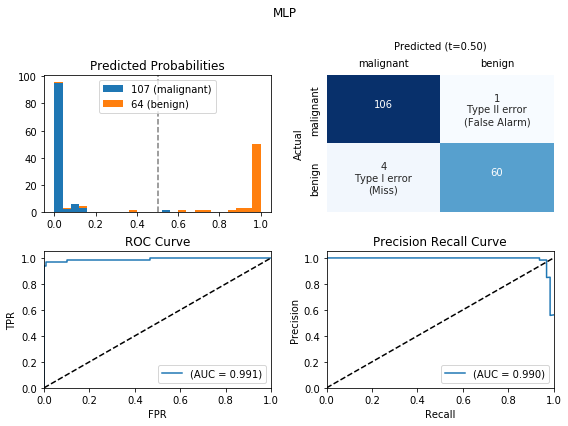

In [12]:
y_hat = ppl_mlp.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], title="MLP")

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'mlp__hidden_layer_sizes': [ (32), (16), (32, 16) ],
    'mlp__alpha': [ 1e-5, 1e-6 ],
    'mlp__activation': ["logistic", "relu"],
    'mlp__solver' : ['adam'] # sgd is faster but adam is better
}

gs = GridSearchCV(
    estimator=ppl_mlp,
    param_grid=params,
    n_jobs=4,
    cv=10,
    scoring="roc_auc", # neg_log_loss, f1, average_precision, balanced_accuracy
    return_train_score=True,
    iid=False,
    refit=True,
    verbose=1)

start = time()
gs.fit(X_train, y_train)
print('-> took %.1f seconds' % (time() - start))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  1.0min finished


-> took 61.2 seconds


In [14]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
11,1.919542,0.455490,0.004422,0.002760,relu,1e-06,"(32, 16)",adam,"{'mlp__activation': 'relu', 'mlp__alpha': 1e-0...",0.957333,...,0.999833,0.999332,0.999165,1.000000,1.000000,1.000000,0.999768,0.999967,0.999806,0.000292
2,2.121037,0.438698,0.003935,0.001393,logistic,1e-05,"(32, 16)",adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",0.954667,...,0.995255,0.995890,0.996190,0.996792,0.996257,0.997527,0.997413,0.998939,0.996758,0.000969
5,2.626141,0.439599,0.003871,0.000376,logistic,1e-06,"(32, 16)",adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",0.952000,...,0.995689,0.996358,0.996625,0.996023,0.996190,0.995823,0.997811,0.999436,0.996794,0.001070
3,2.475435,0.296916,0.004162,0.000814,logistic,1e-06,32,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",0.952000,...,0.995322,0.995622,0.996090,0.996625,0.995923,0.996090,0.997181,0.998839,0.996401,0.000945
6,1.427088,0.230173,0.003676,0.000136,relu,1e-05,32,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 1e-0...",0.936000,...,0.996725,0.996658,0.997327,0.998229,0.997293,0.997828,0.997910,0.999337,0.997686,0.000753


{'mlp__activation': 'relu', 'mlp__alpha': 1e-06, 'mlp__hidden_layer_sizes': (32, 16), 'mlp__solver': 'adam'}


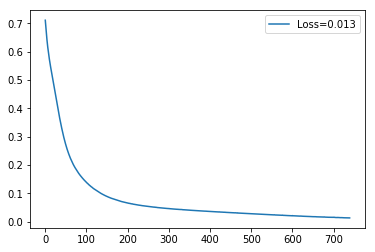

In [15]:
print(gs.best_params_)
gs.best_estimator_.fit(X_train, y_train);
clf = gs.best_estimator_.named_steps['mlp']

show_loss(gs.best_estimator_.named_steps['mlp'])

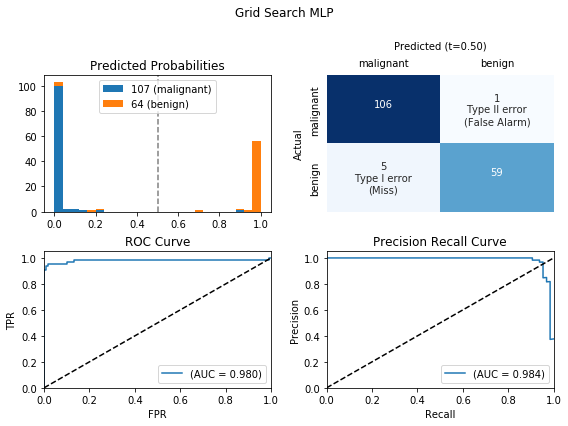

In [16]:
y_hat = gs.best_estimator_.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], 'Grid Search MLP')

## XGBoost

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>


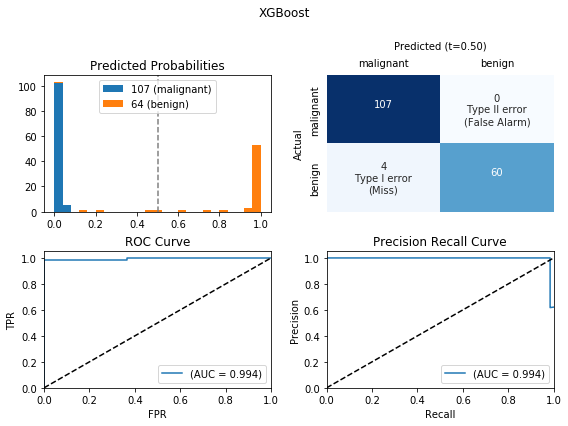

In [17]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=1000)
print(clf.get_params)

clf.fit(X_train, y_train)
y_hat = clf.predict_proba(X_test)[:,1]

show_results(y_test, y_hat, data['target_names'], 'XGBoost')

In [18]:
def plot_importances(booster, importance_type='gain', num_features=20, normalize=True):
    '''See https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score
       xgb_best.feature_importances_ returns normalized "gain"'''
    types = {'weight': 'Number of times used in splits',
             'gain'  : 'Average gain across all splits'}
    s_scores = pd.Series(booster.get_score(importance_type=importance_type))
    if normalize:
        s_scores = s_scores / s_scores.sum()
    s_scores.sort_values(ascending=False).head(n=num_features).plot.barh()
    if importance_type in types:
        plt.title(types[importance_type])
    else:
        plt.title(importance_type)
    plt.gca().invert_yaxis()

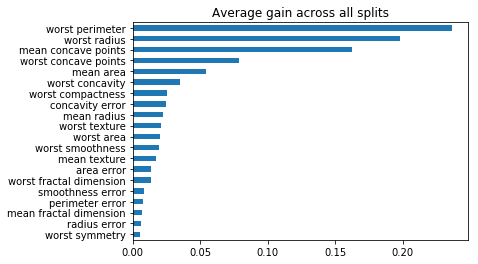

In [19]:
plot_importances(clf.get_booster(), 'gain')